In [1]:
# Text clustering

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [12]:
data = pd.read_json('combined.json', lines=True)
data.head()

,id,title,contents,date,topics,components
0,None,Convicted Bomb Plotter Sentenced to 30 Years,"PORTLAND, Oregon. – Mohamed Osman Mohamud, 23,...",2014-10-01T00:00:00-04:00,[],[National Security Division (NSD)]
1,12-919,$1 Million in Restitution Payments Announced t...,WASHINGTON – North Carolina’s Waccamaw River...,2012-07-25T00:00:00-04:00,[],[Environment and Natural Resources Division]
2,11-1002,$1 Million Settlement Reached for Natural Reso...,BOSTON– A $1-million settlement has been...,2011-08-03T00:00:00-04:00,[],[Environment and Natural Resources Division]
3,10-015,10 Las Vegas Men Indicted \r\nfor Falsifying V...,WASHINGTON—A federal grand jury in Las Vegas...,2010-01-08T00:00:00-05:00,[],[Environment and Natural Resources Division]
4,18-898,$100 Million Settlement Will Speed Cleanup Wor...,"The U.S. Department of Justice, the U.S. Envir...",2018-07-09T00:00:00-04:00,[Environment],[Environment and Natural Resources Division]


In [ ]:
# press releases
# each line represents a Press Release. Fields are as follows:
# id: Press release number (can be missing if included in text)
# title: Title of release
# contents: Text of release
# date: Posted date
# topics: Array of topic tags (if any provided)
# components Array of agencies & departments (if any provided)

In [13]:
# Tf idf
tfidf = TfidfVectorizer(
    min_df = 5,
    max_df = 0.95,
    max_features = 8000,
    stop_words = 'english'
)
tfidf.fit(data.contents)
text = tfidf.transform(data.contents)

Fit 2 clusters
Fit 4 clusters
Fit 6 clusters
Fit 8 clusters
Fit 10 clusters
Fit 12 clusters
Fit 14 clusters
Fit 16 clusters
Fit 18 clusters
Fit 20 clusters


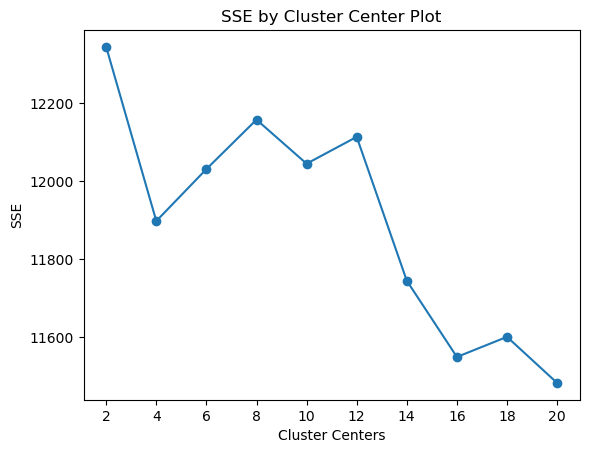

In [14]:
# look for optimal no of clusters
def find_optimal_clusters(data, max_k):
    iters = range(2, max_k+1, 2)
    
    sse = []
    for k in iters:
        sse.append(MiniBatchKMeans(n_clusters=k, init_size=1024, batch_size=2048, random_state=20).fit(data).inertia_)
        print('Fit {} clusters'.format(k))
        
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')
    
find_optimal_clusters(text, 20)

In [15]:
# set k to 6
clusters = MiniBatchKMeans(n_clusters=6, init_size=1024, batch_size=2048, random_state=20).fit_predict(text)

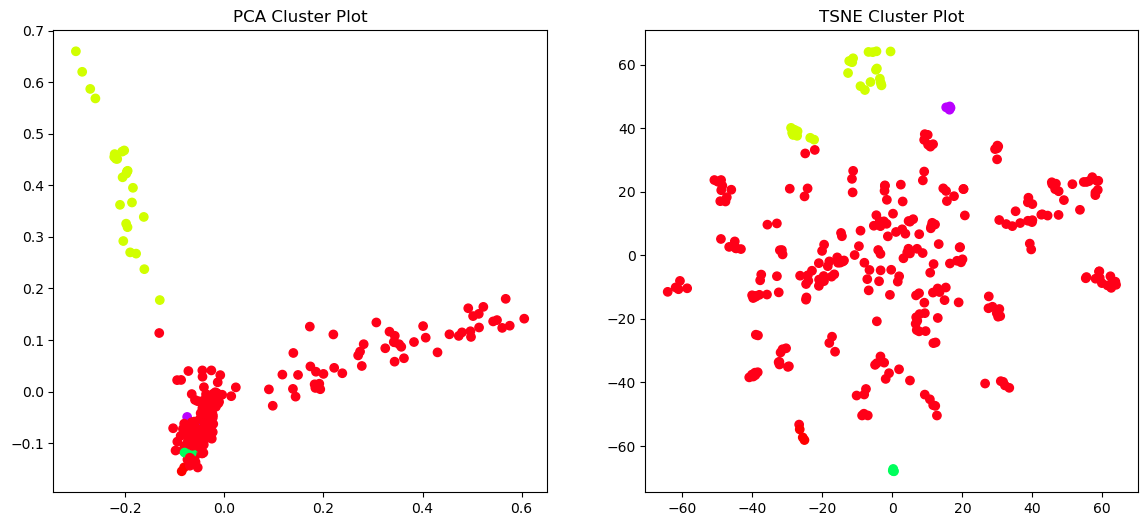

In [16]:
# plot the output
# PCA is better at capturing global structure of the data
# TSNE is better at capturing relations between neighbors
# sample from 3,000 documents and perform a PCA 50 dimension reduction on the data
# next we show a scatterplot further sampling the sample down to 300 pts
def plot_tsne_pca(data, labels):
    max_label = max(labels)
    max_items = np.random.choice(range(data.shape[0]), size=3000, replace=False)
    
   
    pca = PCA(n_components=2).fit_transform(np.asarray(data[max_items,:].todense()))
    tsne = TSNE().fit_transform(PCA(n_components=50).fit_transform(np.asarray(data[max_items,:].todense())))
    
    
    idx = np.random.choice(range(pca.shape[0]), size=300, replace=False)
    label_subset = labels[max_items]
    label_subset = [cm.hsv(i/max_label) for i in label_subset[idx]]
    
    f, ax = plt.subplots(1, 2, figsize=(14, 6))
    
    ax[0].scatter(pca[idx, 0], pca[idx, 1], c=label_subset)
    ax[0].set_title('PCA Cluster Plot')
    
    ax[1].scatter(tsne[idx, 0], tsne[idx, 1], c=label_subset)
    ax[1].set_title('TSNE Cluster Plot')
    
plot_tsne_pca(text, clusters)

In [18]:
# top keywords based on their TFIDF score to see if we can spot any trends
def get_top_keywords(data, clusters, labels, n_terms):
    df = pd.DataFrame(data.todense()).groupby(clusters).mean()
    
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([labels[t] for t in np.argsort(r)[-n_terms:]]))
            
get_top_keywords(text, clusters, tfidf.get_feature_names_out(), 15)


Cluster 0
fairhousing,race,department,apartments,800,persons,civil,rights,lawsuit,act,disabilities,hud,discrimination,fair,housing

Cluster 1
office,home,medicaid,beneficiaries,patients,strike,medical,oig,claims,services,hhs,fraud,care,health,medicare

Cluster 2
origin,impaired,eligibility,anti,255,hotline,provision,status,800,citizenship,immigration,ina,employment,discrimination,osc

Cluster 3
state,foreign,applications,bribes,submitted,admitted,properly,jamie,fraudulent,diplomatic,officials,south,carolina,children,adoption

Cluster 4
selected,california,financial,fraud,properties,public,francisco,san,antitrust,rigging,bid,real,estate,foreclosure,auctions

Cluster 5
case,assistant,civil,returns,indictment,federal,rights,irs,criminal,division,justice,district,department,attorney,tax
